In [2]:
!pip install torch
!pip install numpy
!pip install tqdm
!pip install datetime
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import json
import torch
import numpy as np
from math import floor, ceil
from tqdm import tqdm
from datetime import datetime
from random import shuffle, seed

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class KryptoDataset(torch.utils.data.Dataset):
    def __init__(self, x: list, y: list):
        super().__init__()
        self.data = [x, y]

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, index):
        return self.data[0][index], self.data[1][index]


def generate_causal_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask


class EnhancedLSTMSkipBlock(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout: float):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm_dropout = torch.nn.Dropout(dropout)
        self.lstm_norm = torch.nn.LayerNorm(hidden_size)
        self.lstm_activation = torch.nn.Mish()

        # Улучшенные свертки
        self.conv = torch.nn.Conv1d(hidden_size, hidden_size, kernel_size=5,
                             padding=2, groups=hidden_size)

        self.dilated_conv = torch.nn.Conv1d(
            hidden_size, hidden_size, kernel_size=3, padding=2, dilation=2)
        self.norm = torch.nn.LayerNorm(hidden_size)

        self.activation = torch.nn.Mish()

        # Регуляризация
        self.dropout = torch.nn.Dropout(dropout)
        self.res_scale = torch.nn.Parameter(torch.ones(1))

        # Проекция
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.Dropout(dropout / 2)
        ) if input_size != hidden_size else None

        # Инициализация
        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                torch.nn.init.orthogonal_(param)
        torch.nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        residual = x

        # Новый порядок операций:
        out, _ = self.lstm(x)
        out = self.lstm_norm(out)
        out = self.lstm_activation(out)
        out = self.lstm_dropout(out)

        # Обработка конволюциями
        x_permuted = out.permute(0, 2, 1)
        conv_out = self.conv(x_permuted).permute(0, 2, 1)
        dilated_out = self.dilated_conv(x_permuted).permute(0, 2, 1)

        out = conv_out + dilated_out
        out = self.norm(out)
        out = self.activation(out)
        out = self.dropout(out)

        if self.proj is not None:
            residual = self.proj(residual)

        return out + residual * self.res_scale


class KryptoModelWithAttention(torch.nn.Module):
    def __init__(self, size: list, dropout=0.2, num_attention_heads_2=4, avg=1):
        super().__init__()
        num_attention_heads_1 = size[0]
        num_layers = len(size) - 1
        self.size = size
        self.avg = avg

        self.attention_layer = torch.nn.MultiheadAttention(embed_dim=size[0], num_heads=num_attention_heads_1,
                                                           dropout=dropout, batch_first=True)
        self.attention_norm = torch.nn.LayerNorm(size[0])
        self.attention_act = torch.nn.Mish()

        for p in self.attention_layer.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

        self.unattention_layer = torch.nn.MultiheadAttention(embed_dim=size[0], num_heads=num_attention_heads_1,
                                                           dropout=dropout, batch_first=True)
        self.unattention_norm = torch.nn.LayerNorm(size[0])
        self.unattention_act = torch.nn.Mish()

        for p in self.unattention_layer.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)


        self.layers = torch.nn.ModuleList()

        for i in range(num_layers):
            self.layers.append(EnhancedLSTMSkipBlock(size[i], size[i+1], dropout).to(DEVICE))

        self.glodal_attention_norm = torch.nn.LayerNorm(size[-1])
        self.glodal_attention = torch.nn.MultiheadAttention(embed_dim=size[-1], num_heads=num_attention_heads_2,
                                                           dropout=dropout, batch_first=True)
        self.global_act = torch.nn.Mish()

        self.agr = torch.nn.AdaptiveAvgPool1d(avg)
        self.fc = torch.nn.Linear(size[-1]*avg, 5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        feature_weights = torch.softmax(x, dim=1)

        feature_unweights = torch.abs(1 - torch.softmax(x, dim=1))

        mask = generate_causal_mask(x.shape[1]).to(x.device)

        x_norm = self.attention_norm(x)
        feature_weights = torch.softmax(x_norm, dim=-1)  # Softmax по фичам
        values = feature_weights * x_norm
        x_1, _ = self.attention_layer(x_norm, x_norm, values, attn_mask=mask)

        # Аналогично для unattention
        x_unorm = self.unattention_norm(x)
        feature_unweights = 1 - torch.softmax(x_unorm, dim=1)
        unvalues = feature_unweights * x_unorm
        x_2, _ = self.unattention_layer(x_unorm, x_unorm, unvalues, attn_mask=mask)

        # Добавлен шлюз для комбинирования ветвей
        x = self.attention_act(x_1) + self.unattention_act(x_2)


        for layer in self.layers:
            x = layer(x)    # LSTM


        mask = generate_causal_mask(x.shape[1]).to(x.device)

        x_global = self.glodal_attention_norm(x)
        x_attn, _ = self.glodal_attention(x_global, x_global, x_global, attn_mask=mask)
        x = x + self.global_act(x_attn)

        x = self.agr(x.permute(0, 2, 1)).squeeze()
        if self.avg != 1:
            x = x.flatten(1)
        x = self.fc(x)
        x = self.relu(x)

        return torch.log(x + 1)


def cyclic_encode(unit, mode: str):
    angle = None
    if mode == 'hour':
        angle = 2 * np.pi * unit / 24
    elif mode == 'day':
        angle = 2 * np.pi * unit / 7
    elif mode == 'month':
        angle = 2 * np.pi * unit / 12
    return np.sin(angle), np.cos(angle)


def make_data(file_name, general_size: float):
    main_data = None
    with open(file_name, 'r') as js_file:
        main_data = json.load(js_file)

    X = []
    Y = []
    feat = []

    seed(1)
    keys = list(main_data.keys())
    BTC = keys[:1]
    keys = keys[1:]
    shuffle(keys)
    keys = BTC + keys[:200]

    logs = set()
    max_values = [-1 for i in range(19)]
    calculated_maximums = []

    for key in tqdm(list(keys), 'Dataset loading :'):
        support, timestamps, open_price, high_price, low_price, close_price, volume = main_data[key]
        if len(open_price) < 200:
            continue
        if general_size != 1:
            lenth = len(open_price)
            support, timestamps, open_price, high_price, low_price, close_price, volume = support, timestamps[-int(lenth*general_size):], open_price[-int(lenth*general_size):], high_price[-int(lenth*general_size):], low_price[-int(lenth*general_size):], close_price[-int(lenth*general_size):], volume[-int(lenth*general_size):]
        for i in range(1, len(open_price)):
            try:
                backapp = max_values.copy()
                contdition = True
                feat = []
                for ind in range(60):
                    num1 = open_price[i + ind]
                    num2 = high_price[i + ind]
                    num3 = low_price[i + ind]
                    num4 = close_price[i + ind]
                    num5 = volume[i + ind]

                    dem1 = open_price[i + ind - 1]
                    dem2 = high_price[i + ind - 1]
                    dem3 = low_price[i + ind - 1]
                    dem4 = close_price[i + ind - 1]
                    dem5 = volume[i + ind - 1]
                    if num1 == 0 or num2 == 0 or num3 == 0 or num4 == 0 or num5 == 0 or dem1 == 0 or dem2 == 0 or dem3 == 0 or dem4 == 0 or dem5 == 0:
                        contdition = False
                        break

                    time_code = timestamps[i + ind] / 1000
                    time_obj: datetime = datetime.fromtimestamp(timestamp=time_code)
                    hour_sin, hour_cos = cyclic_encode(time_obj.hour, 'hour')
                    day_sin, day_cos = cyclic_encode(time_obj.weekday(), 'day')
                    month_sin, month_cos = cyclic_encode(time_obj.month - 1, 'month')

                    step_data = [np.log((num1 / dem1) + 1),
                                np.log((num2 / dem2) + 1),
                                np.log((num3 / dem3) + 1),
                                np.log((num4 / dem4) + 1),
                                np.log((num5 / dem5) + 1),
                                np.log((num4 / num1) + 1),
                                np.log((num2 / num3) + 1),
                                np.log(max(((min(num1, num4) - num3) / num4) + 1, 1)),
                                np.log(num1 + 1),
                                np.log(num2 + 1),
                                np.log(num3 + 1),
                                np.log(num4 + 1),
                                np.log(num5 + 1),
                                hour_sin,
                                hour_cos,
                                day_sin,
                                day_cos,
                                month_sin,
                                month_cos]

                    if any(x > 5 for x in step_data[:5]):
                        contdition = False
                        break

                    for i in range(len(step_data)):
                        max_values[i] = max(max_values[i], step_data[i])

                    feat.append(step_data)

                if contdition == False:
                    max_values = backapp
                    continue
                ind = 60 + i

                feat = np.array(feat.copy(), dtype=np.float32)
                if (feat.shape[0] != 60 and feat.shape[1] != len(step_data)) or np.isin(np.nan, feat).item():
                    logs.add('not full window')
                    max_values = backapp
                    continue

                num1 = open_price[ind]
                num2 = high_price[ind]
                num3 = low_price[ind]
                num4 = close_price[ind]
                num5 = volume[ind]

                dem1 = open_price[ind - 1]
                dem2 = high_price[ind - 1]
                dem3 = low_price[ind - 1]
                dem4 = close_price[ind - 1]
                dem5 = volume[ind - 1]
                if num1 == 0 or num2 == 0 or num3 == 0 or num4 == 0 or num5 == 0 or dem1 == 0 or dem2 == 0 or dem3 == 0 or dem4 == 0 or dem5 == 0:
                    max_values = backapp
                    continue

                target = [np.log((num1 / dem1) + 1),
                          np.log((num2 / dem2) + 1),
                          np.log((num3 / dem3) + 1),
                          np.log((num4 / dem4) + 1),
                          np.log((num5 / dem5) + 1)]

                if any(x > 5 for x in target):
                    max_values = backapp
                    continue

                for i in range(len(target)):
                    max_values[i] = max(max_values[i], step_data[i])

                y = np.array(target, dtype=np.float32)

                X.append(feat)
                Y.append(y)
            except Exception as exp:
                if exp.args[-1] != 'list index out of range':
                    logs.add(exp.args[-1])
                max_values = backapp
                continue

    print(f'\nlogs: {list(logs)};\n')
    print(max_values, '\n')
    return X, Y


def make_dataset(file_name='full_candles_data.json', train_size: float=0.8, general_size: float=1):
    X_data, Y_data = make_data(file_name, general_size)
    lenth = len(Y_data)

    train_x, val_x = X_data[:floor(lenth * train_size)], X_data[ceil(lenth * train_size):]
    train_y, val_y = Y_data[:floor(lenth * train_size)], Y_data[ceil(lenth * train_size):]

    return KryptoDataset(train_x, train_y), KryptoDataset(val_x, val_y)


def mape(y_true: torch.Tensor, y_pred: torch.Tensor):
    y_true = torch.expm1(y_true)
    y_pred = torch.expm1(y_pred)
    diff = torch.abs((y_true - y_pred)) / torch.abs(y_true)
    return 100 * torch.mean(diff)


def direct_loss(y_true: torch.Tensor, y_pred: torch.Tensor):
    y_true = torch.exp(y_true) - 1
    y_pred = torch.exp(y_pred) - 1
    mask_true = y_true >= 1
    mask_pred = y_pred >= 1
    result_mask = mask_pred == mask_true
    result_mask = result_mask.int()
    return result_mask.sum() / torch.tensor(result_mask.shape[0] * result_mask.shape[1])


def run(model, loader, loss_function=torch.nn.MSELoss, optimizer=None):
    label = 'Epoch'
    if optimizer is None:
        model.eval()
        label = 'Val'
    else:
        model.train()
        label = 'Train'

    MAPE = 0
    error = 0
    direct = 0

    with torch.set_grad_enabled(optimizer is not None):
        for x, y in tqdm(loader, f'{label} iterations :'):
            x, y = x.to(torch.float32), y.to(torch.float32)
            x, y = x.to(DEVICE), y.to(DEVICE)
            predict = model(x)
            loss = loss_function(predict, y)
            error += loss.item()
            MAPE += mape(y, predict).item()
            direct += direct_loss(y, predict).item()

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=True)

                optimizer.step()

    return error / len(loader), MAPE / len(loader), direct / len(loader)


class MAPELoss(torch.nn.Module):
    def __init__(self, alpha=0.7):
        super().__init__()
        self.alpha = alpha  # Вес для направления (0.5-0.9)

    def forward(self, y_pred, y_true):
        # # Восстановление исходных значений с защитой от переполнения
        y_true_orig = torch.expm1(y_true)  # exp(y) - 1
        y_pred_orig = torch.expm1(y_pred)

        # # 1. Вычисление направления относительно порога 1
        # dir_true = torch.sign(y_true_orig - 1.0)  # {-1, 0, 1}
        # dir_pred = torch.sign(y_pred_orig - 1.0)

        # # 2. Косинусное сходство направлений с учетом величины отклонения
        # magnitude_true = torch.abs(y_true_orig - 1.0)
        # magnitude_pred = torch.abs(y_pred_orig - 1.0)
        # cosine_sim = (dir_true * dir_pred) * torch.min(
        #     magnitude_true, magnitude_pred
        # ) / (magnitude_true + magnitude_pred)

        # # 3. Нормализованный штраф за направление
        # direction_loss = (1 - (cosine_sim.mean() + 1) / 2)  # [0, 1]
        growth_penalty = torch.sum((y_pred_orig - 1) * (y_true_orig < 1).float())
        decline_penalty = torch.sum((1 - y_pred_orig) * (y_true_orig > 1).float())

        mape = torch.mean(torch.abs(y_true - y_pred) / y_true)

        # 5. Адаптивный баланс компонент
        total_loss = (
            mape + growth_penalty + decline_penalty
        )

        return total_loss


class simpleMAPE(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        return torch.mean(torch.abs(y_true - y_pred) / y_true) * 100


def train(model: torch.nn.Module, t_loader, v_loader, EPOCHS=100):
    best_model = None

    crietion = simpleMAPE()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-4)
    sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

    counter = 0
    train_metrs, val_metrs = [], []
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        if epoch == 1:
            best_model = model.state_dict()
            # for g in optimizer.param_groups:
            #     g['lr'] = 0.5e-5
        train_loss, train_MAPE, train_direct = run(model, t_loader, crietion, optimizer)
        val_loss, val_MAPE, val_direct = run(model, v_loader, crietion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrs.append(train_MAPE)
        val_metrs.append(val_MAPE)

        sheduler.step(val_MAPE)

        print(f'\nEpoch {epoch+1}:\n  Train loss - {train_loss}, Train MAPE - {train_MAPE},\n  Train dirrectional - {train_direct};\n  Val loss - {val_loss}, Val MAPE - {val_MAPE},\n  Val dirrectional - {val_direct};\n  LR = {sheduler.get_last_lr()[-1]}.\n\n')

        if len(val_losses) > 1:
            if val_loss > min(val_losses):
                counter += 1
            else:
                counter = 0
                best_model = model.state_dict()

            if counter >= 7:
                return best_model, train_losses, val_losses, train_metrs, val_metrs

    return best_model, train_losses, val_losses, train_metrs, val_metrs

if __name__ == '__main__':
    print(DEVICE.upper(), '\n')
    krpt_model = KryptoModelWithAttention(size=(19, 32, 64, 128, 256), dropout=0.25, avg=1)
    krpt_model = krpt_model.to(torch.float32)
    krpt_model = krpt_model.to(DEVICE)

    train_dataset, val_dataset = make_dataset('sample_data/full_candles_data_1d.json', train_size=0.8, general_size=1)

    print(f'Train lenth: {len(train_dataset)}, Val lenth: {len(val_dataset)}.')
    print()

    train_loader, val_loader = torch.utils.data.DataLoader(train_dataset, 64, True, pin_memory=True), torch.utils.data.DataLoader(val_dataset, 64, pin_memory=True)

    trained_weights, train_losses, val_losses, train_metrs, val_metrs = train(krpt_model, train_loader, val_loader)
    torch.save(trained_weights, 'sample_data/weights.pth')

CUDA 



Dataset loading :: 100%|██████████| 201/201 [04:52<00:00,  1.46s/it]



logs: [];

[4.255376275250388, 3.332088673350548, 4.091284328925506, 1.6929131427148865, 4.991027269136557, 1.4535722564127678, 8.503007331933736, 0.6928179624499758, 11.572559667071173, 11.604492283495649, 11.564782255563966, 11.572559667071173, 31.654878289661074, 0.0, 1.0, 0.9749279121818236, 1.0, 1.0, 1.0] 

Train lenth: 116260, Val lenth: 29065.



Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 96.23it/s] 



Epoch 1:
  Train loss - 25.028114067963603, Train MAPE - 26.50881460438604,
  Train dirrectional - 0.5229980839958673;
  Val loss - 28.169459349244505, Val MAPE - 31.750514137351907,
  Val dirrectional - 0.4471016576001932;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 105.49it/s]



Epoch 2:
  Train loss - 23.278918049528368, Train MAPE - 24.540948657853036,
  Train dirrectional - 0.5362074357110456;
  Val loss - 26.17329818390228, Val MAPE - 28.793429154616135,
  Val dirrectional - 0.4356356919139296;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 95.59it/s]



Epoch 3:
  Train loss - 23.12875318868382, Train MAPE - 24.33281365238708,
  Train dirrectional - 0.5422374834611512;
  Val loss - 25.342948976453844, Val MAPE - 27.567591908213856,
  Val dirrectional - 0.42625000791235285;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 105.98it/s]



Epoch 4:
  Train loss - 23.03671113803089, Train MAPE - 24.205171000386702,
  Train dirrectional - 0.5494301622886217;
  Val loss - 24.951269577361725, Val MAPE - 26.990913852230534,
  Val dirrectional - 0.4241346232674934;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 106.31it/s]



Epoch 5:
  Train loss - 22.973840910849102, Train MAPE - 24.11780998007439,
  Train dirrectional - 0.5541924767167475;
  Val loss - 24.693550147591058, Val MAPE - 26.609195809835917,
  Val dirrectional - 0.4241140188915389;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 96.24it/s] 



Epoch 6:
  Train loss - 22.93047241752595, Train MAPE - 24.056966782665935,
  Train dirrectional - 0.5572863277919226;
  Val loss - 24.802486461597486, Val MAPE - 26.768512029962224,
  Val dirrectional - 0.4241277551421752;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 105.81it/s]



Epoch 7:
  Train loss - 22.880276049633373, Train MAPE - 23.986688333615277,
  Train dirrectional - 0.5622513958990542;
  Val loss - 24.698596564492025, Val MAPE - 26.609319892296423,
  Val dirrectional - 0.4310508321111019;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 97.05it/s]



Epoch 8:
  Train loss - 15.262613366840302, Train MAPE - 17.243297729114285,
  Train dirrectional - 0.5646471713818754;
  Val loss - 13.590112079106845, Val MAPE - 18.683133657555004,
  Val dirrectional - 0.439278854904594;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 106.43it/s]



Epoch 9:
  Train loss - 8.041247522955619, Train MAPE - 10.727182156316644,
  Train dirrectional - 0.5647744412729224;
  Val loss - 13.949917735110272, Val MAPE - 19.15912892268254,
  Val dirrectional - 0.4439148446524536;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 105.97it/s]



Epoch 10:
  Train loss - 7.837283527582113, Train MAPE - 10.455201948351695,
  Train dirrectional - 0.580863232443998;
  Val loss - 14.137236981339507, Val MAPE - 19.570867268593755,
  Val dirrectional - 0.43227183496231564;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 98.43it/s] 



Epoch 11:
  Train loss - 7.6614200736902935, Train MAPE - 10.22346547362433,
  Train dirrectional - 0.5914155774937925;
  Val loss - 14.477525673331796, Val MAPE - 20.343992227512402,
  Val dirrectional - 0.43644231659370464;
  LR = 5e-06.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 105.48it/s]



Epoch 12:
  Train loss - 7.565406494371564, Train MAPE - 10.095098605704425,
  Train dirrectional - 0.5952396082169549;
  Val loss - 14.935732881315461, Val MAPE - 20.978827710204072,
  Val dirrectional - 0.43438187686951607;
  LR = 5.000000000000001e-07.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 98.33it/s]



Epoch 13:
  Train loss - 7.511531239626627, Train MAPE - 10.01771197820274,
  Train dirrectional - 0.5992843559402388;
  Val loss - 14.798666872297014, Val MAPE - 20.800679178552315,
  Val dirrectional - 0.4379327013597384;
  LR = 5.000000000000001e-07.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 105.73it/s]



Epoch 14:
  Train loss - 7.50253349171934, Train MAPE - 10.009656404884687,
  Train dirrectional - 0.5988280180068744;
  Val loss - 14.77684874167809, Val MAPE - 20.749960278940726,
  Val dirrectional - 0.43760989884753804;
  LR = 5.000000000000001e-07.




Val iterations :: 100%|██████████| 455/455 [00:04<00:00, 106.07it/s]


Epoch 15:
  Train loss - 7.497250798644767, Train MAPE - 10.001740738265648,
  Train dirrectional - 0.5987704980156877;
  Val loss - 14.812991083585299, Val MAPE - 20.803125883458733,
  Val dirrectional - 0.4378228112236484;
  LR = 5.000000000000001e-07.




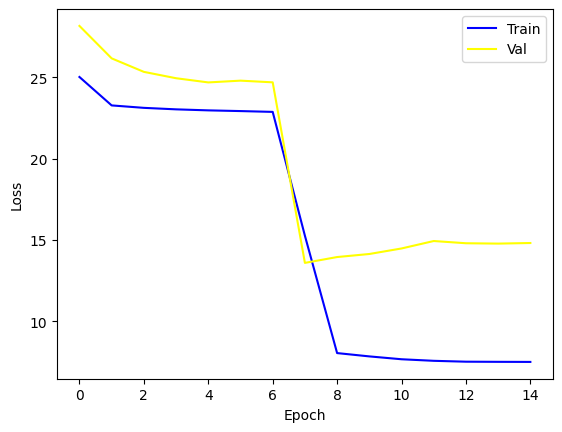

In [8]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(train_losses))], train_losses, color='blue', label='Train')
plt.plot( [i for i in range(len(val_losses))], val_losses, color='yellow', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

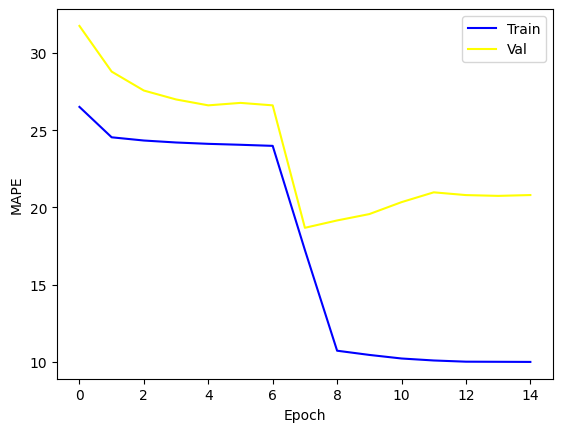

In [9]:
plt.plot([i for i in range(len(train_metrs))], train_metrs, color='blue', label='Train')
plt.plot([i for i in range(len(val_metrs))], val_metrs, color='yellow', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.show()